In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (16, 8)

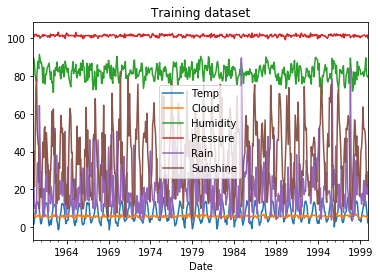

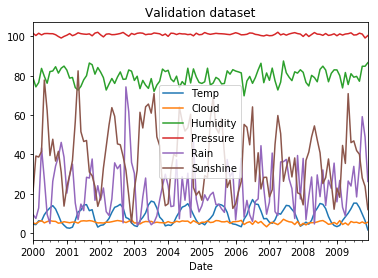

In [2]:
# Parse date strings as datetime objects
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')

#####################
# Read datafiles and combine into a single dataframe
temperature_data = pd.read_csv('data/TG_STAID001825.txt', 
                                header=15,
                                usecols=[2, 3, 4],
                                names=["Date","Temp","Valid"],
                                parse_dates=["Date"], date_parser=dateparse,
                                index_col="Date")
temperature_data = temperature_data[temperature_data.Valid == 0]   # Only consider 'valid' measurements
temperature_data = temperature_data[temperature_data.Temp != -9999]# Only consider 'valid' measurements
temperature_data = temperature_data.resample("M").mean()           # Resample date to once a month
temperature_data.Temp = temperature_data.Temp * 0.1                # Scale to sensible units (degC)

cloud_data = pd.read_csv('data/CC_STAID001825.txt', 
                        header=15,
                        usecols=[2, 3, 4],
                        names=["Date","Cloud","Valid"],
                        parse_dates=["Date"], date_parser=dateparse,
                        index_col="Date")
cloud_data = cloud_data[cloud_data.Valid == 0]                     # Only consider 'valid' measurements
cloud_data = cloud_data[cloud_data.Cloud != -9999]                 # Only consider 'valid' measurements
cloud_data = cloud_data.resample("M").mean()                       # Resample date to once a month

humidity_data = pd.read_csv('data/HU_STAID001825.txt', 
                            header=15,
                            usecols=[2, 3, 4],
                            names=["Date","Humidity","Valid"],
                            parse_dates=["Date"], date_parser=dateparse,
                            index_col="Date")
humidity_data = humidity_data[humidity_data.Valid == 0]             # Only consider 'valid' measurements
humidity_data = humidity_data[humidity_data.Humidity != -9999]      # Only consider 'valid' measurements
humidity_data = humidity_data.resample("M").mean()                  # Resample date to once a month

pressure_data = pd.read_csv('data/PP_STAID001825.txt', 
                            header=15,
                            usecols=[2, 3, 4],
                            names=["Date","Pressure","Valid"],
                            parse_dates=["Date"], date_parser=dateparse,
                            index_col="Date")
pressure_data = pressure_data[pressure_data.Valid == 0]              # Only consider 'valid' measurements
pressure_data = pressure_data[pressure_data.Pressure != -9999]       # Only consider 'valid' measurements
pressure_data = pressure_data.resample("M").mean()                   # Resample date to once a month
pressure_data.Pressure = pressure_data.Pressure * (1./ 100.)         # Scale to sensible units (kPa)

rain_data = pd.read_csv('data/RR_STAID001825.txt', 
                            header=16,
                            usecols=[2, 3, 4],
                            names=["Date","Rain","Valid"],
                            parse_dates=["Date"], date_parser=dateparse,
                            index_col="Date")
rain_data = rain_data[rain_data.Valid == 0]                          # Only consider 'valid' measurements
rain_data = rain_data[rain_data.Rain != -9999]                       # Only consider 'valid' measurements
rain_data = rain_data.resample("M").mean()                           # Resample date to once a month

sunshine_data = pd.read_csv('data/SS_STAID001825.txt', 
                            header=15,
                            usecols=[2, 3, 4],
                            names=["Date","Sunshine","Valid"],
                            parse_dates=["Date"], date_parser=dateparse,
                            index_col="Date")
sunshine_data = sunshine_data[sunshine_data.Valid == 0]              # Only consider 'valid' measurements
sunshine_data = sunshine_data[sunshine_data.Sunshine != -9999]       # Only consider 'valid' measurements
sunshine_data = sunshine_data.resample("M").mean()                   # Resample date to once a month

# Make combined dataset
data = pd.concat([temperature_data, cloud_data, humidity_data,
                  pressure_data, rain_data, sunshine_data], axis=1)
data = data.drop("Valid", axis=1)                                    # Prune away the 'valid' columns

# Use data from 1960 - 2000 to train and 2000 - 2010 to validate
training_data = data.loc['1960-01-01':'2000-01-01']
validation_data = data.loc['2000-01-01':'2010-01-01']

# Missing value treatment - replace nans with previous value
cols = data.columns
for col in cols:
    for i in range(0,len(training_data)):
        if np.isnan(data[col][i]):
            data[col][i] = data[col][i-1]

# Make units dictionary for later
units={"Temp"       : "degC",
        "Cloud"     : "oktas",
        "Humidity"  : "%",
        "Pressure"  : "Pa",
        "Rain"      : "0.1 mm",
        "Sunshine"  : "0.1 hours"}

# Plot for reference
plt.figure()
training_data.plot(title="Training dataset")
validation_data.plot(title="Validation dataset")

In [3]:
# Define some helper functions for the following analysis

In [4]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 

    # Print Summary
    print "Augmented Dickey-Fuller Test on {0}".format(name)
    print '-'*47
    print "Null Hypothesis: Data has unit root. Non-Stationary."
    print "Significance Level    = {0:.3f}".format(signif)
    print "Test Statistic        = {0:.3f}".format(output["test_statistic"])
    print "No. Lags Chosen       = {0:.1f}".format(output["n_lags"])

    for key,val in r[4].items():
        print "Critical value {0} = {1:.3f}".format(key, val)

    if p_value <= signif:
        print "=> P-Value = {0:.3e}. Rejecting Null Hypothesis.".format(p_value)
        print '-'*30
        print "=> Series is Stationary."
    else:
        print "=> P-Value = {0:.3f}. Weak evidence to reject the Null Hypothesis."
        print '-'*30
        print "=> Series is Non-Stationary."
    print '-'*30


In [19]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print "Y = {0}, X = {1}, P Values = {2}".format(r, c, p_values)
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(training_data, variables = training_data.columns)

,Temp_x,Cloud_x,Humidity_x,Pressure_x,Rain_x,Sunshine_x
Temp_y,1.0,0.0001,0.0000,0.0000,0.0009,0.0000
Cloud_y,0.0,1.0000,0.0000,0.0023,0.0000,0.0000
Humidity_y,0.0,0.0000,1.0000,0.0056,0.4530,0.0000
Pressure_y,0.0,0.0266,0.0008,1.0000,0.7554,0.0000
Rain_y,0.0,0.0198,0.0005,0.0013,1.0000,0.0001
Sunshine_y,0.0,0.0000,0.0002,0.0491,0.0086,1.0000


In [6]:
#####################################################
# The Granger’s Causality Test (above) checks that the
# past values of time series (X) do not cause the 
# other series (Y). 
# So, if the p-value obtained from the test is less
# than the significance level of 0.05, then one can
# safely reject the null hypothesis.
# For every instance where the values in the above table 
# are < 0.05 we can concolude the corresponding 
# parameters arestrongly related to one another.
#
# The fact that most variables show some dependance on
# the other variables makes this data a good candidate
# for Vector Auto-regression (VAR)! 
# 
# Another sensible check of suitability for VAR is the
# cointegration test... See below
#####################################################

In [7]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
# Use cointegration test to stablish the presence of a statistically significant connection between datea series
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    
    # Summary
    print "Name   ::  Test Stat > C(95%)    =>   Signif"
    print '--'*20
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print "{0}   :: {1:.2f} > {2:.3f} \t=> {3}".format(col, trace, cvt, (trace>cvt))

cointegration_test(training_data)

Name   ::  Test Stat > C(95%)    =>   Signif
----------------------------------------
Temp   :: 439.86 > 83.938 	=> True
Cloud   :: 267.13 > 60.063 	=> True
Humidity   :: 183.19 > 40.175 	=> True
Pressure   :: 107.37 > 24.276 	=> True
Rain   :: 49.84 > 12.321 	=> True
Sunshine   :: 0.03 > 4.130 	=> False


In [8]:
#####################################################
# The above table suggests the majority of our
# variables are cointegrated so will perform well
# in a VAR model
#####################################################

In [9]:
#####################################################
# Finally, for VAR to perform well we need to
# have stationary data sets. Use the ADF test
# to check we don't need to do any differencing /
# seaonaity removal
for name, column in training_data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

Augmented Dickey-Fuller Test on Temp
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level    = 0.050
Test Statistic        = -3.280
No. Lags Chosen       = 14.0
Critical value 5% = -2.868
Critical value 1% = -3.444
Critical value 10% = -2.570
=> P-Value = 1.580e-02. Rejecting Null Hypothesis.
------------------------------
=> Series is Stationary.
------------------------------


Augmented Dickey-Fuller Test on Cloud
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level    = 0.050
Test Statistic        = -9.553
No. Lags Chosen       = 5.0
Critical value 5% = -2.868
Critical value 1% = -3.444
Critical value 10% = -2.570
=> P-Value = 0.000e+00. Rejecting Null Hypothesis.
------------------------------
=> Series is Stationary.
------------------------------


Augmented Dickey-Fuller Test on Humidity
-----------------------------------------------
Null Hypoth

In [20]:
#####################################################
# All series are already stationary so no need
# for differencing decomposing the seasonality
#####################################################

In [21]:
# Use the statsmodel package to make a VAR mode
from statsmodels.tsa.api import VAR
model = VAR(training_data)
# Find the best performing order hyperparameter for this dataset
order_selection = model.select_order(maxlags=8)
order_selection.summary()

,AIC,BIC,FPE,HQIC
0,11.84,11.89,1.388e+05,11.86
1,8.856,9.225*,7013.,9.001
2,8.591,9.278,5385.,8.862
3,8.430,9.434,4585.,8.825*
4,8.399*,9.720,4446.*,8.919
5,8.446,10.08,4661.,9.090
6,8.453,10.41,4697.,9.222
7,8.491,10.76,4884.,9.385
8,8.473,11.06,4805.,9.491


In [12]:
# Fit the model using the appropriate order and check there's no remaining pattern in the residuals
model_fitted = model.fit(4)

# In the Durban-Watson test the value of the statistic can vary between 0 and 4. 
# The closer it is to the value 2, then there is no significant serial correlation
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
for col, val in zip(training_data.columns, out):
    print "{0} : {1:.2f}".format(col, val)

Temp : 2.06
Cloud : 1.99
Humidity : 2.00
Pressure : 1.99
Rain : 2.00
Sunshine : 2.01


Monthly average forcaset returns the following RMSE comparing to 5 years of validation data
RMSE_Temp = 1.952 [degC]
RMSE_Cloud = 0.463 [oktas]
RMSE_Humidity = 4.115 [%]
RMSE_Pressure = 0.557 [Pa]
RMSE_Rain = 14.193 [0.1 mm]
RMSE_Sunshine = 11.332 [0.1 hours]


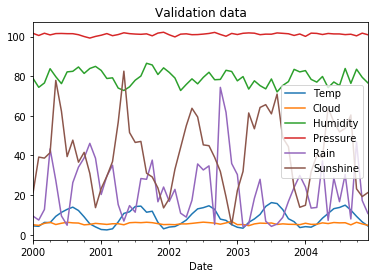

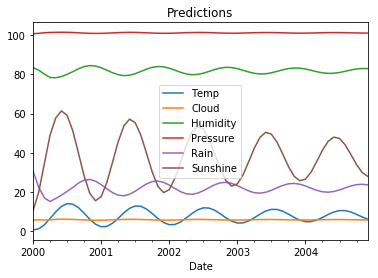

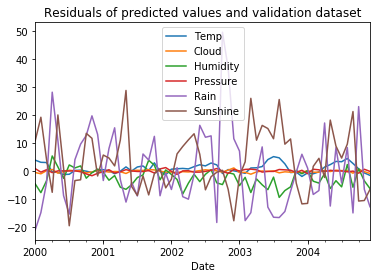

In [25]:
n_forcast_years = 5
validation_data = data.loc['2000-01-01':'20{0:02d}-01-01'.format(n_forcast_years)]

# Use the fitted model to produce a forcast over the duration of our validation data
lag_order = model_fitted.k_ar
forecast_input = training_data.values[-lag_order:]
fc = model_fitted.forecast(y=forecast_input, steps=len(validation_data))
forecast = pd.DataFrame(fc, index=validation_data.index, columns=validation_data.columns)

# Make some plots 
validation_data.plot(title="Validation data")
forecast.plot(title="Predictions")
residuals = validation_data.subtract(forecast, axis='columns')
residuals.plot(title="Residuals of predicted values and validation dataset")

# Print RMSE to screen
import sklearn.metrics
print "Monthly average forcaset returns the following RMSE comparing to {0} years of validation data".format(n_forcast_years)
for col in validation_data.columns:
    print "RMSE_{0} = {1:.3f} [{2}]".format(col,
                                        np.sqrt(sklearn.metrics.mean_squared_error(forecast[col], validation_data[col])),
                                        units[col])